In [1]:
import numpy as np
import pandas as pd
from helper.Loader import Loader
import matplotlib.pyplot as plt
import seaborn as sns
from helper.get_data import pivot_table_all
database = 'market_research'
table_name = 'ohlc'
start_date = "2012-01-01"
end_date = "2022-01-26"

"""
"""
wind_codes = pd.read_csv('beer.txt',sep=' ', header=None,)
wind_codes = wind_codes[0].to_list()
field = "symbol,date,close"
# options = "PriceAdj=DP"
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.head()
table = pivot_table_all(df, 'date', 'symbol', 'close')
# print(table)


Data found!


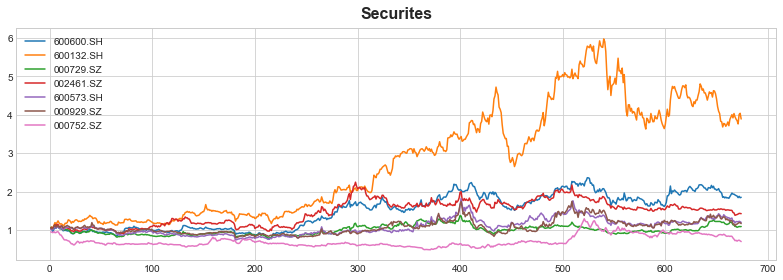

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
fig, ax = plt.subplots()
for wind_code in wind_codes:
    df0 = table[wind_code]
    # df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    df0 = df0["2019-05":]
    df0['Time'] = np.arange(len(df0.index))
    df0['pct'] = df0[wind_code].pct_change()
    df0['cumprod'] = (df0['pct'] + 1).cumprod()
    # ax = df0.plot(**plot_params)
    ax.plot('Time', 'cumprod', data=df0, label=wind_code)
    # ax = sns.regplot(x='Time', y=wind_code, data=df0, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Securites');
    _ = ax.legend()

In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None, title='Periodograms'):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(f"{title}")
    return ax

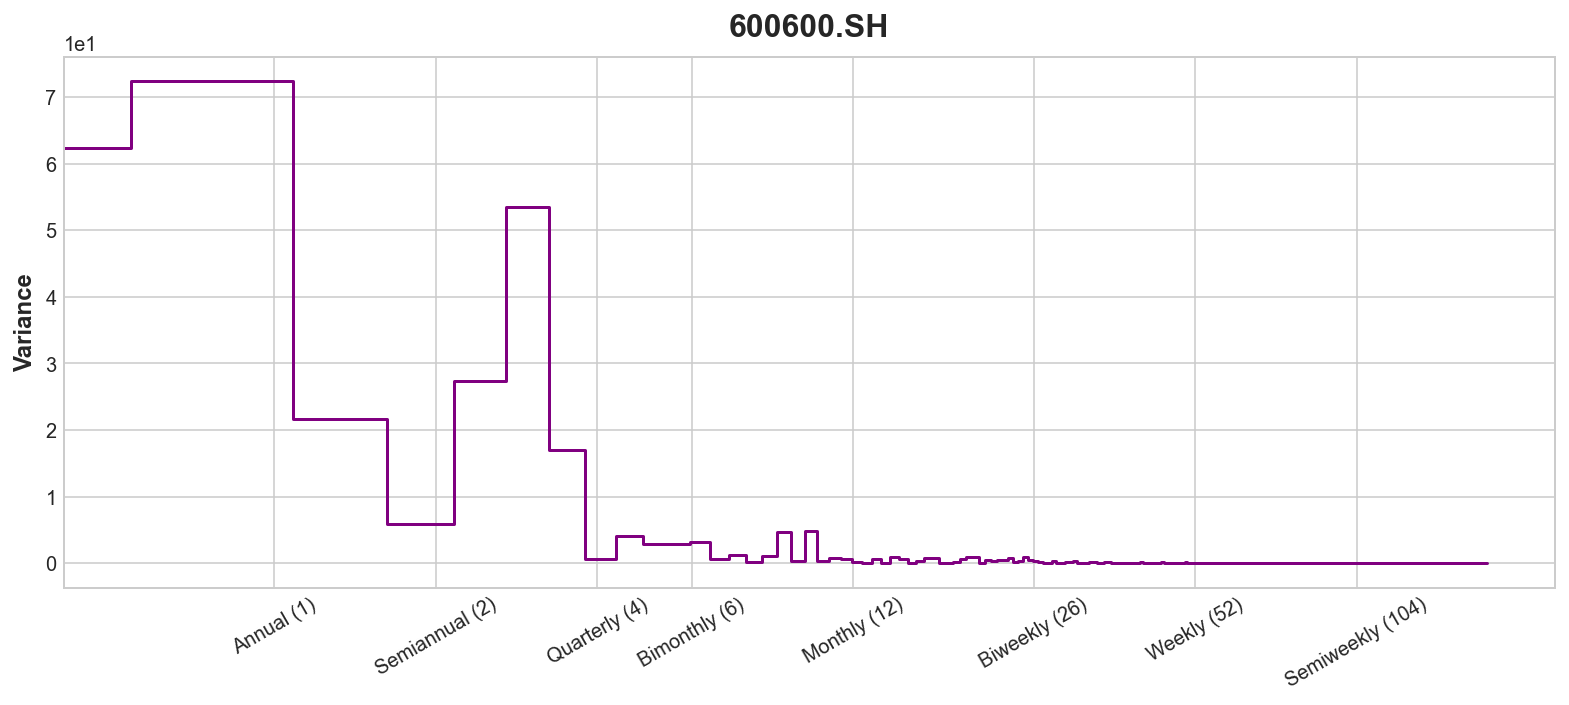

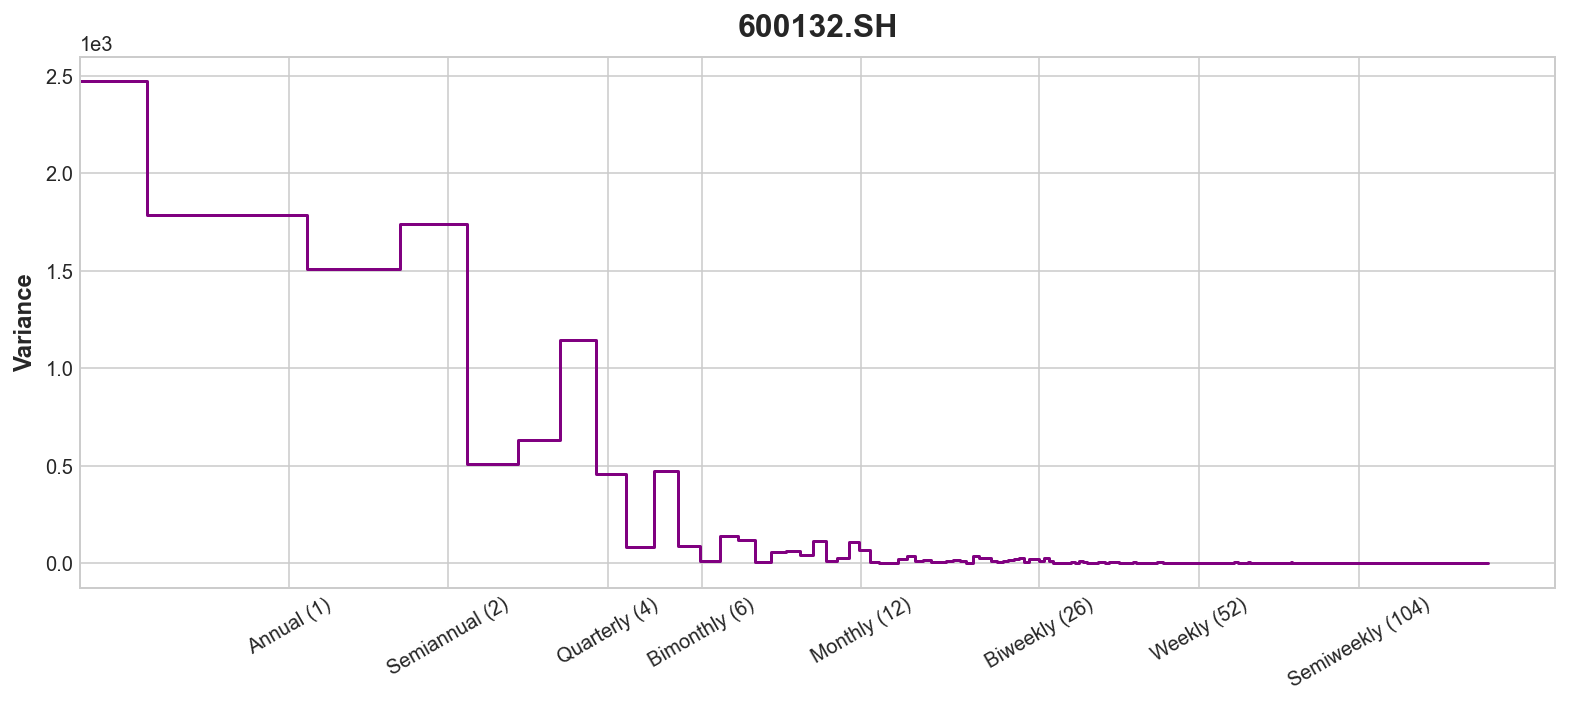

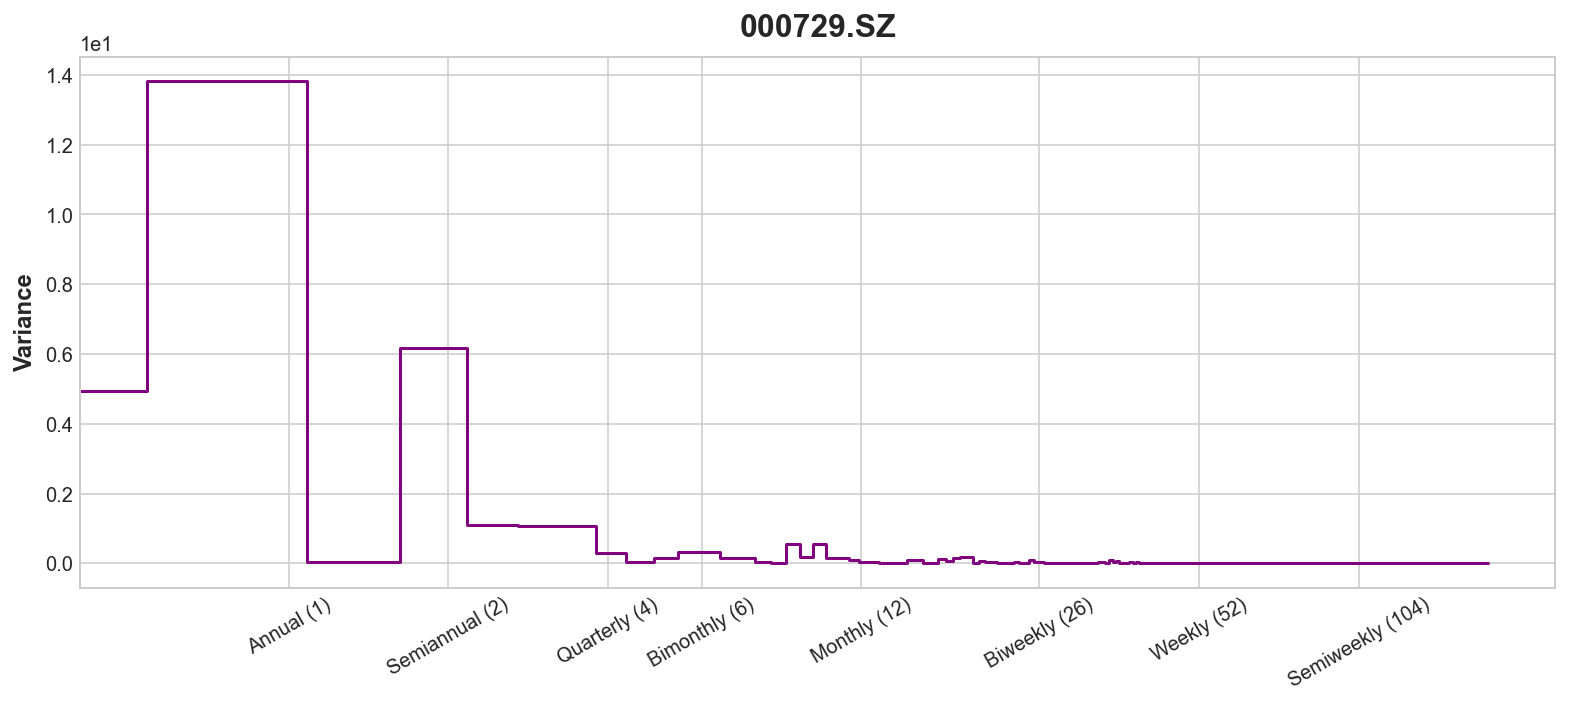

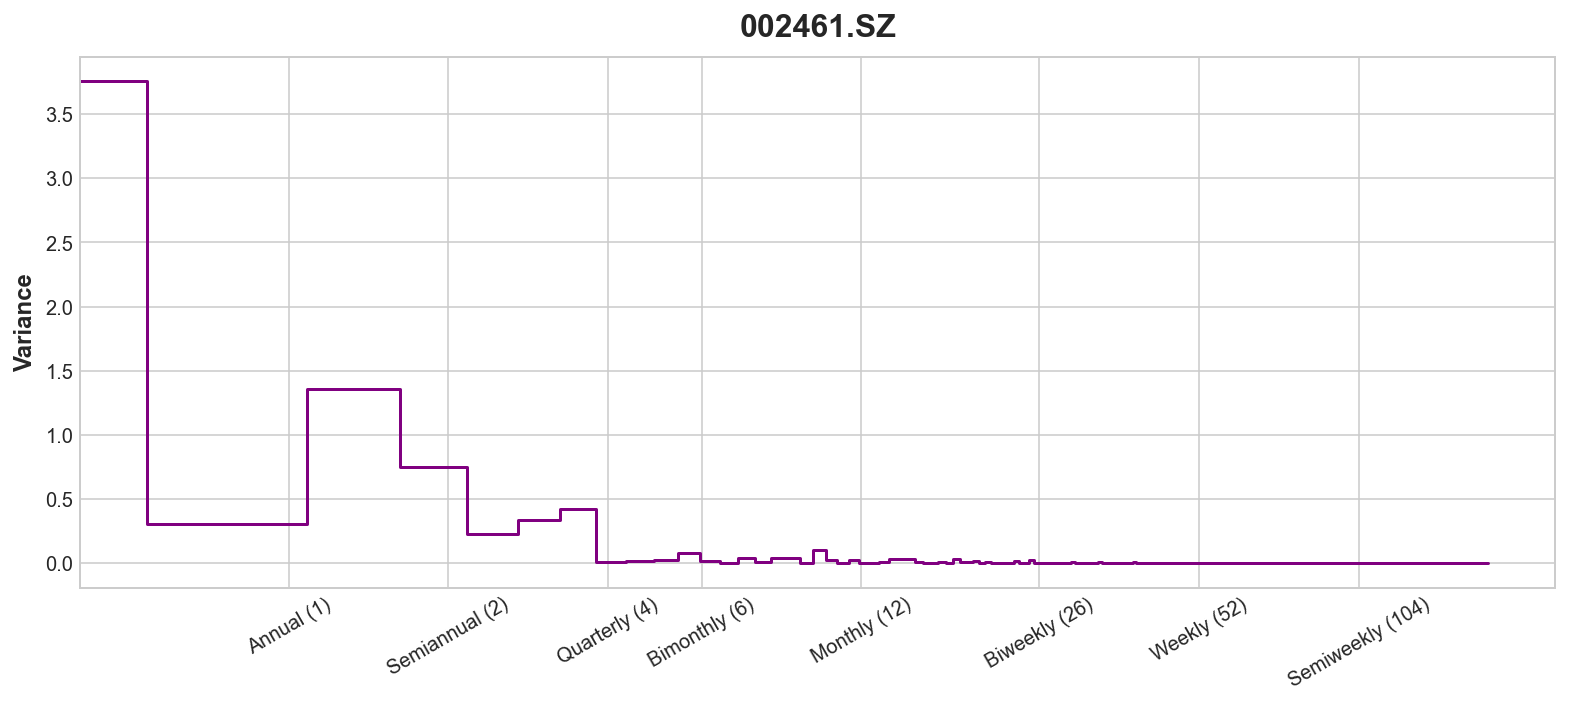

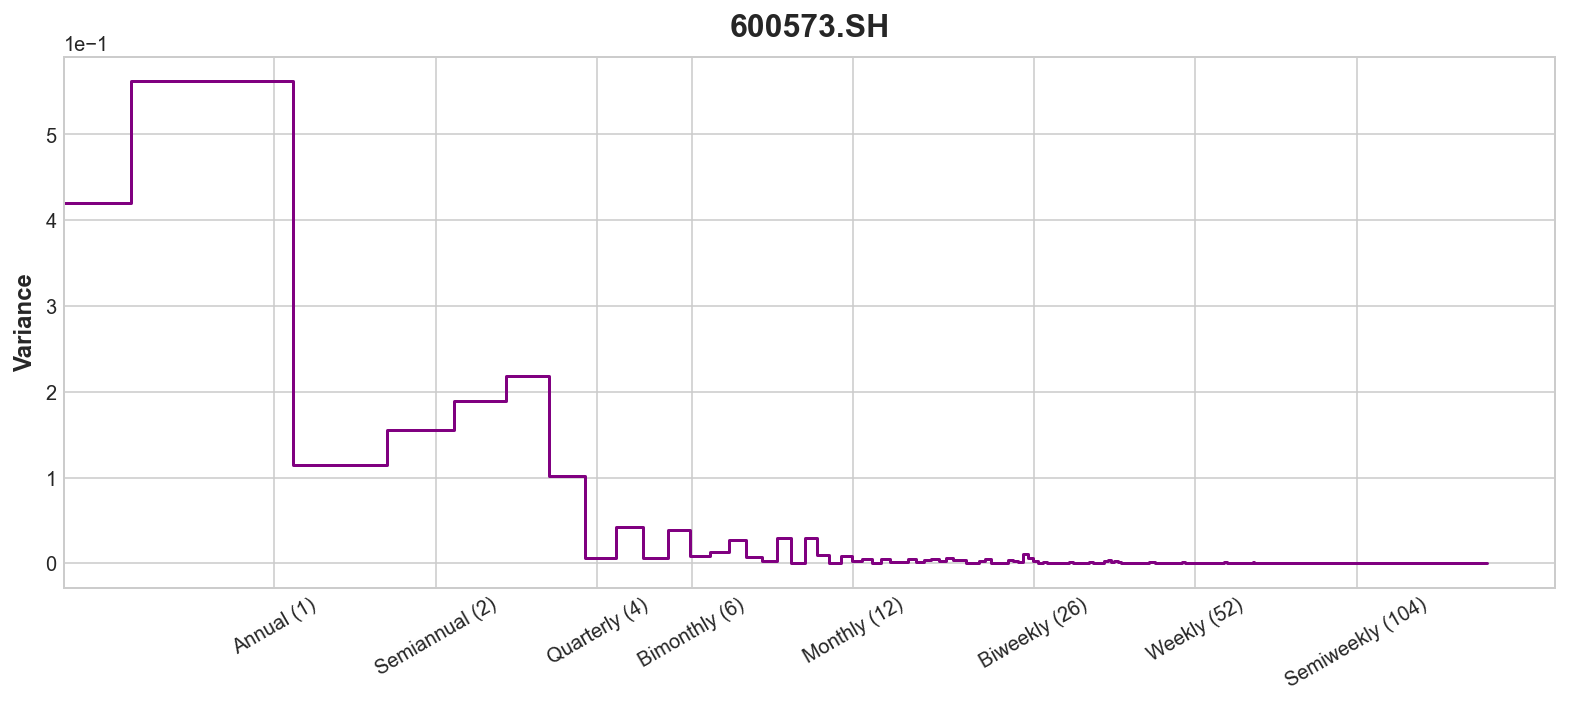

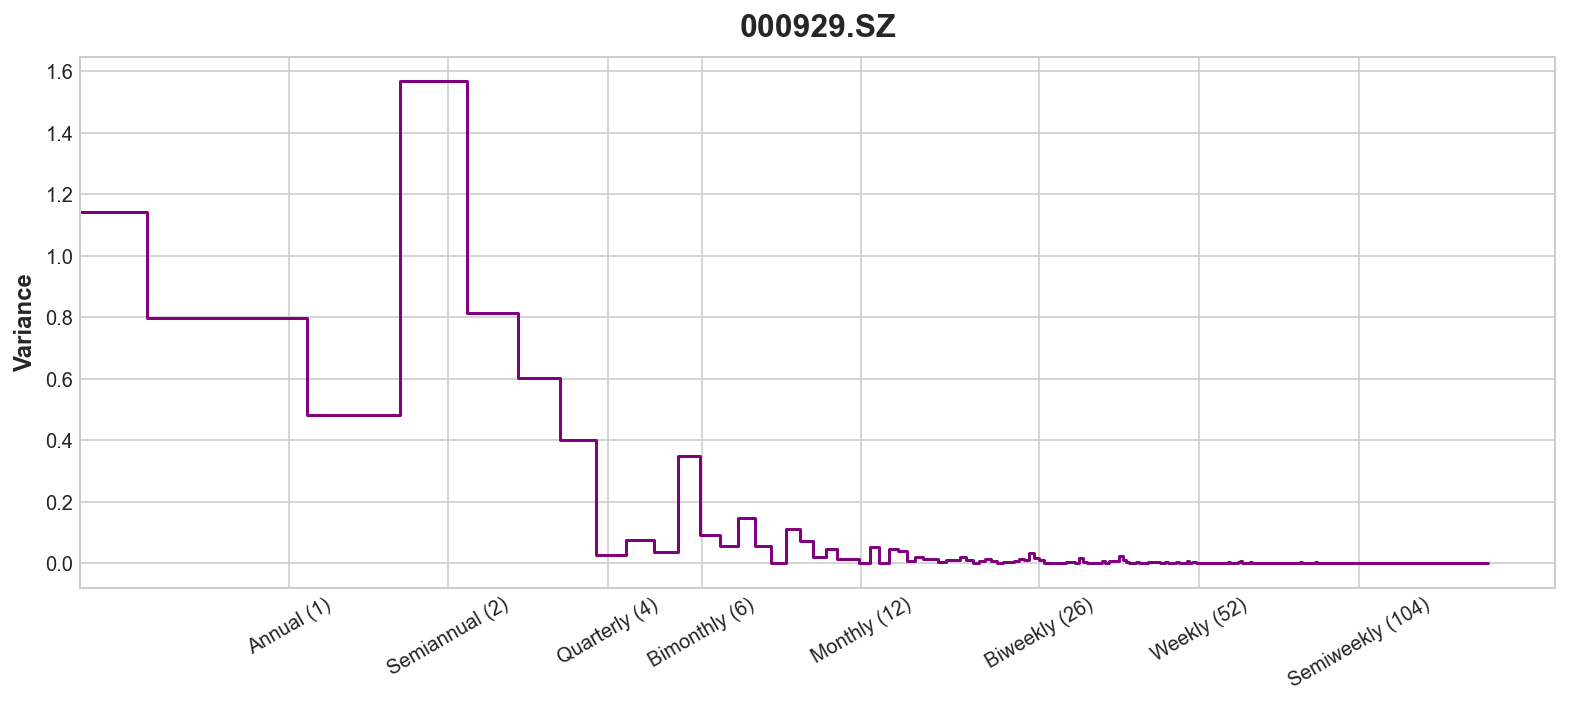

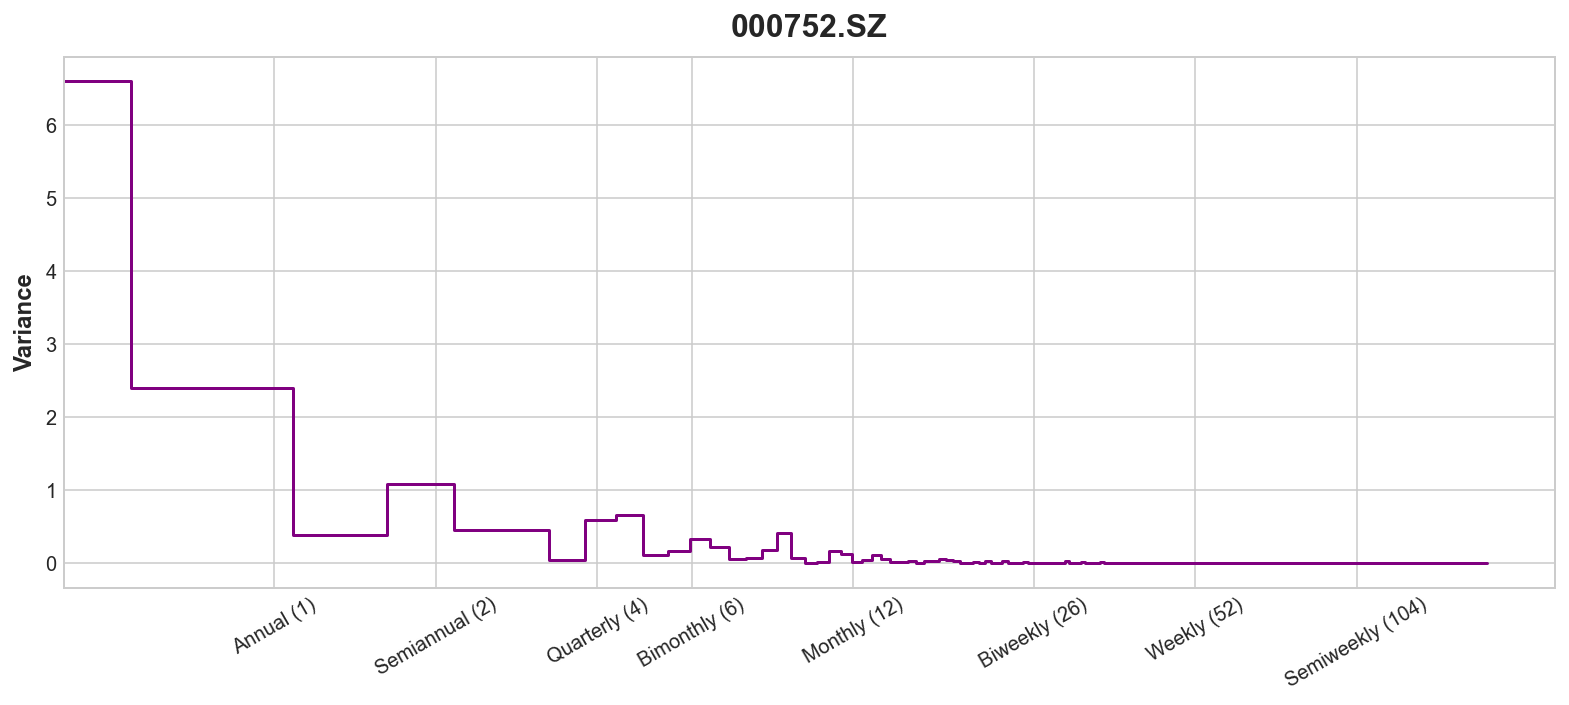

In [4]:
for wind_code in wind_codes:
    df0 = table[wind_code]["2019-05":]
    df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    # df0 = df0["2019-05":]
    plot_periodogram(df0[wind_code],title=wind_code);

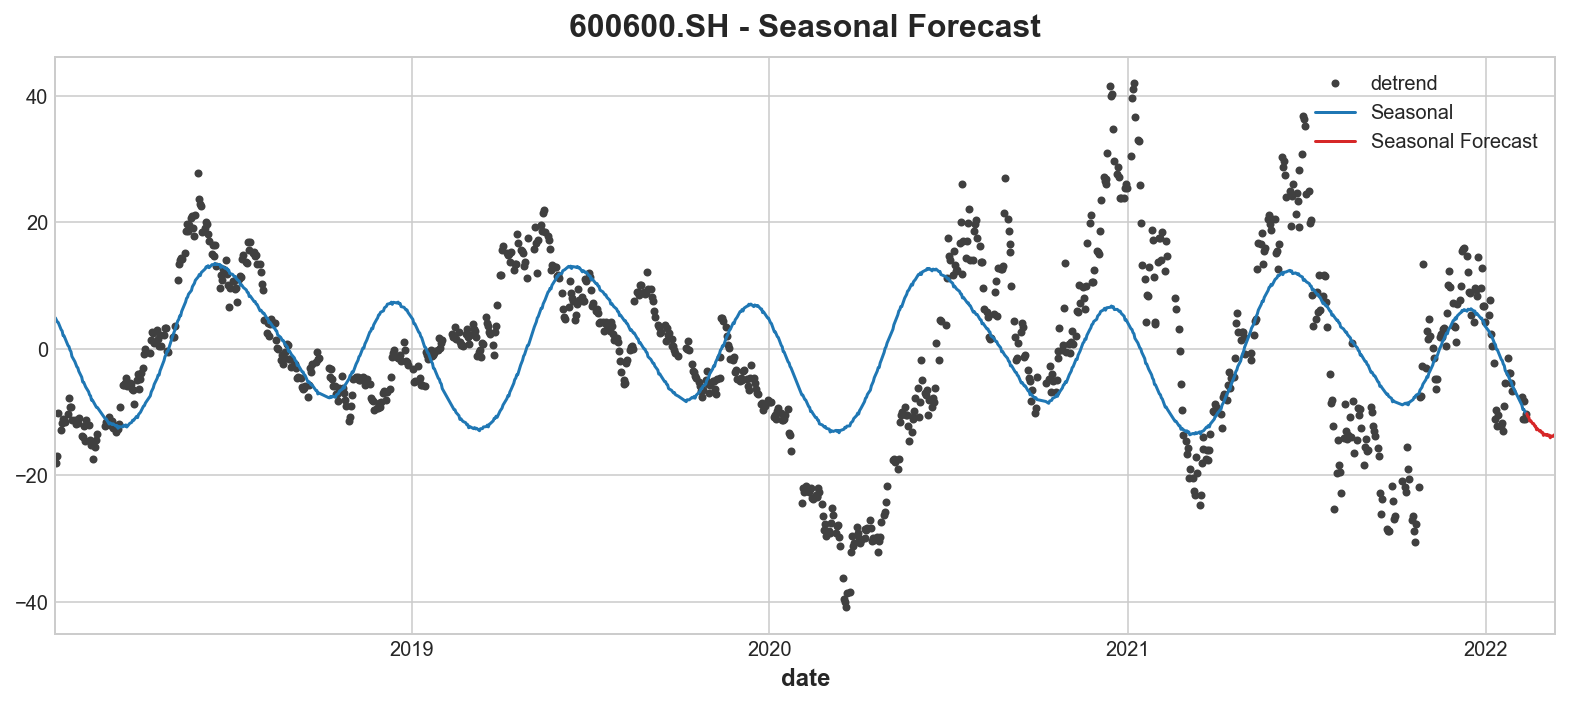

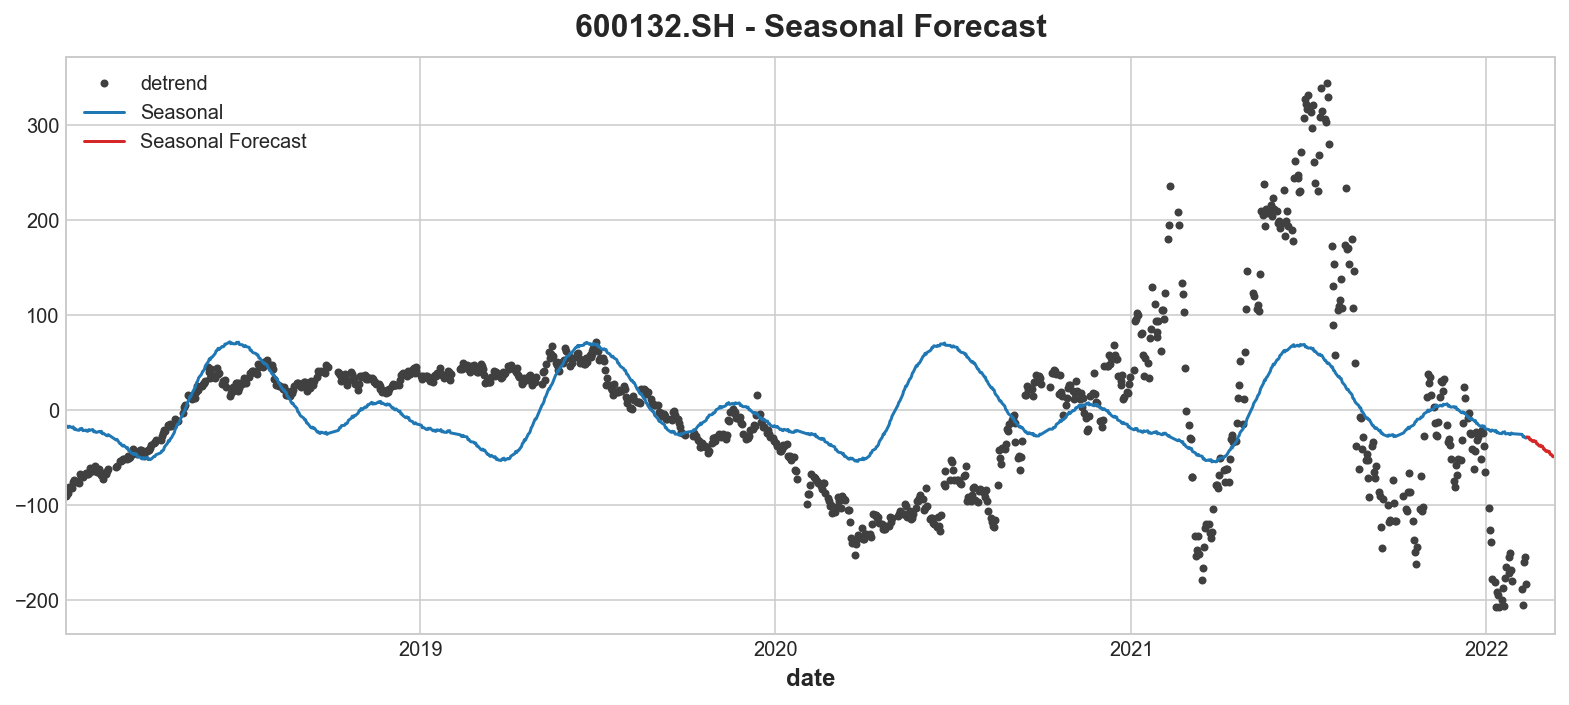

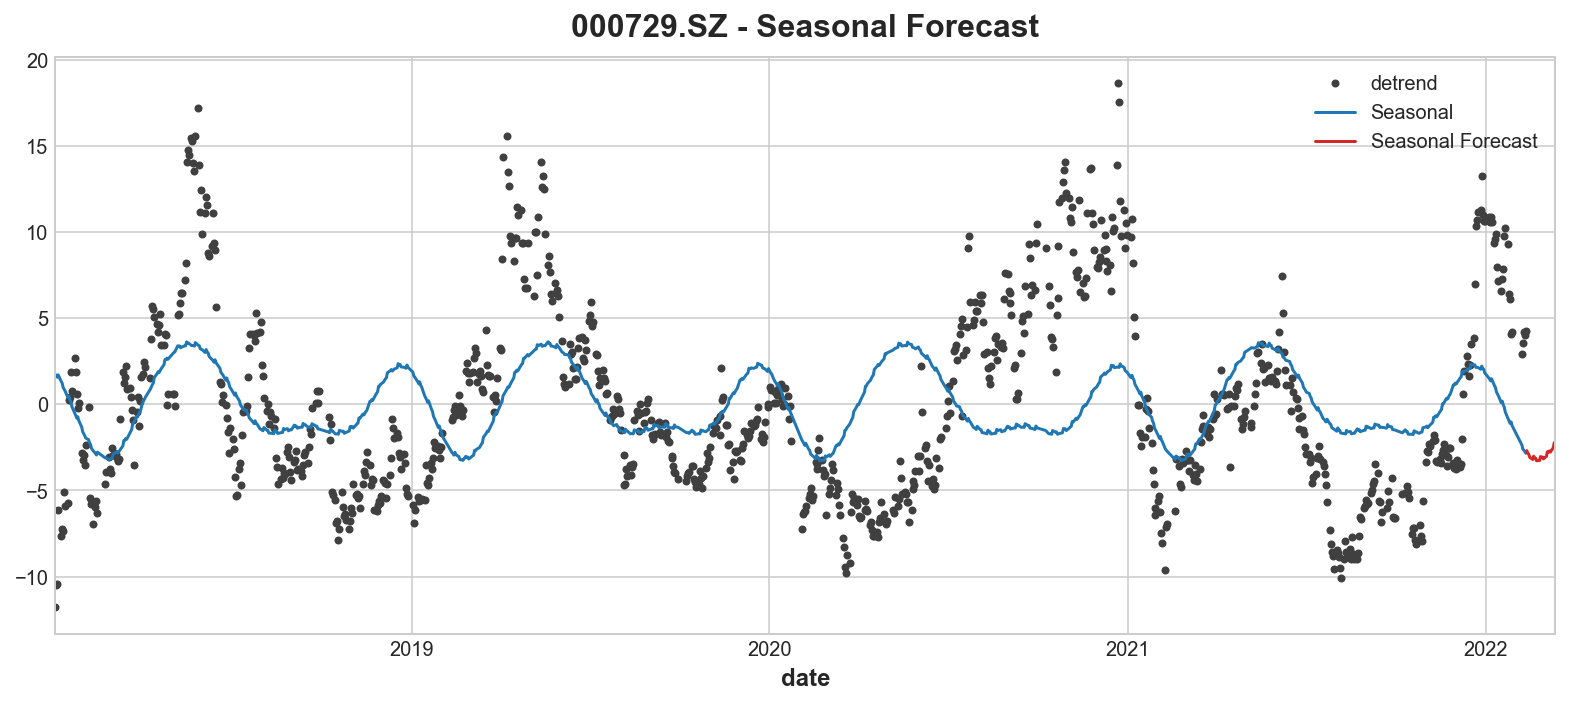

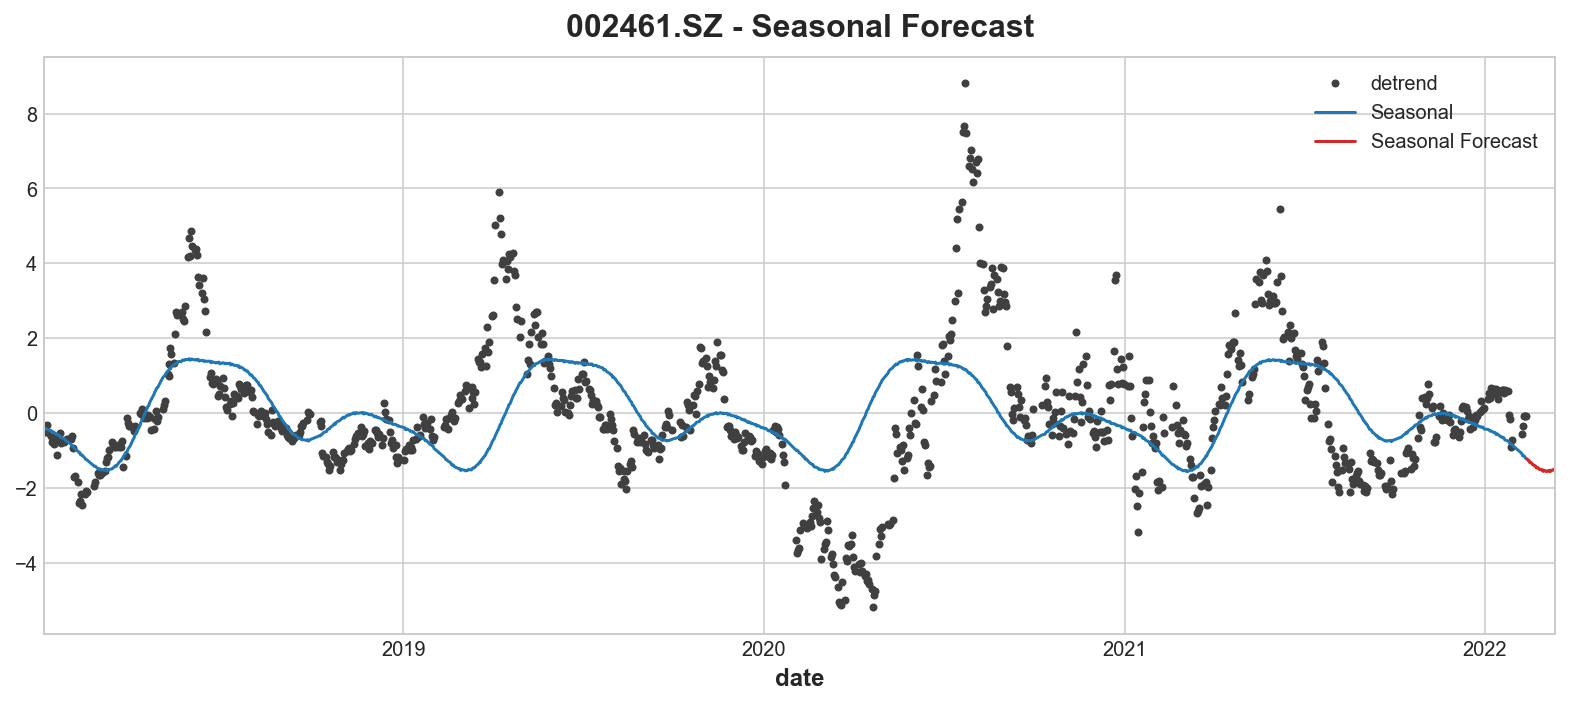

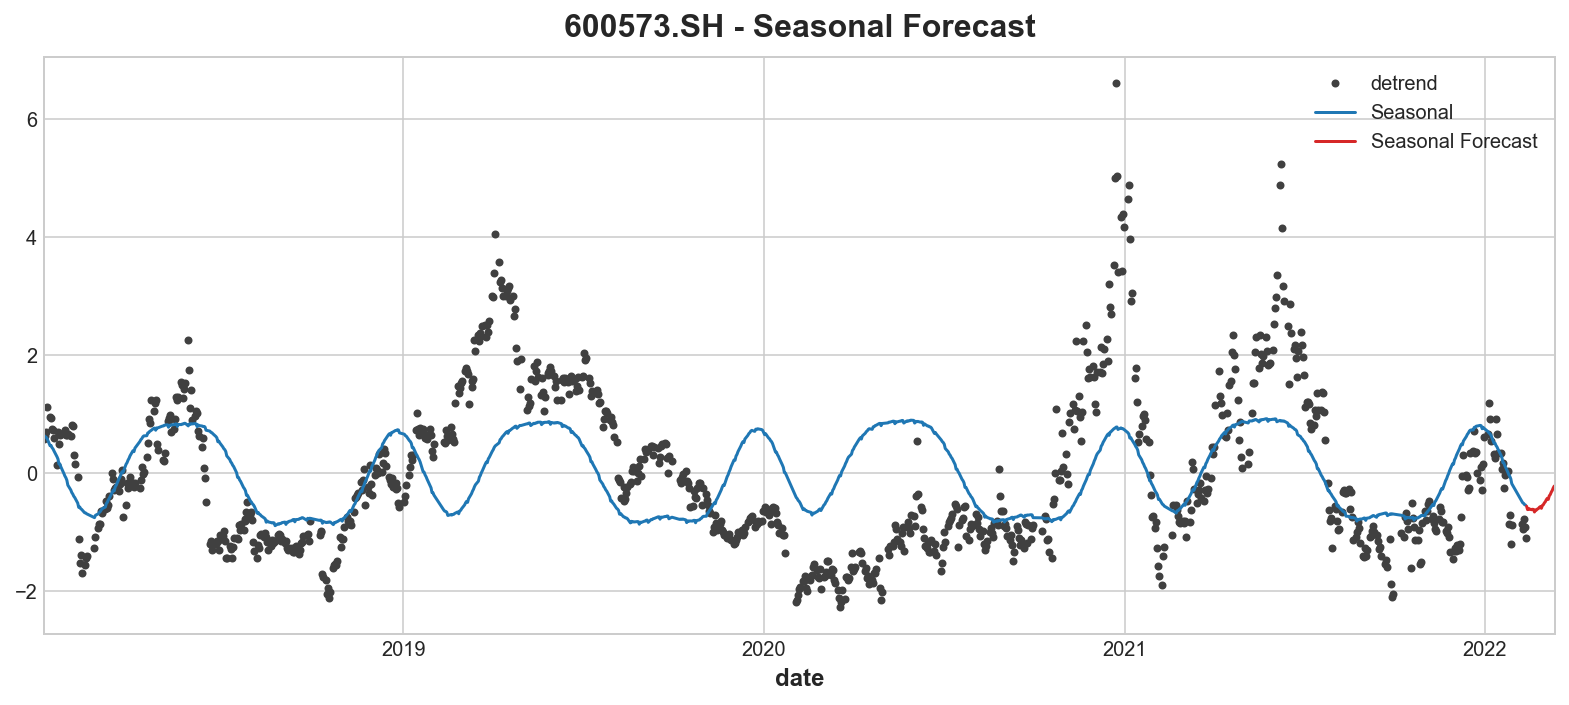

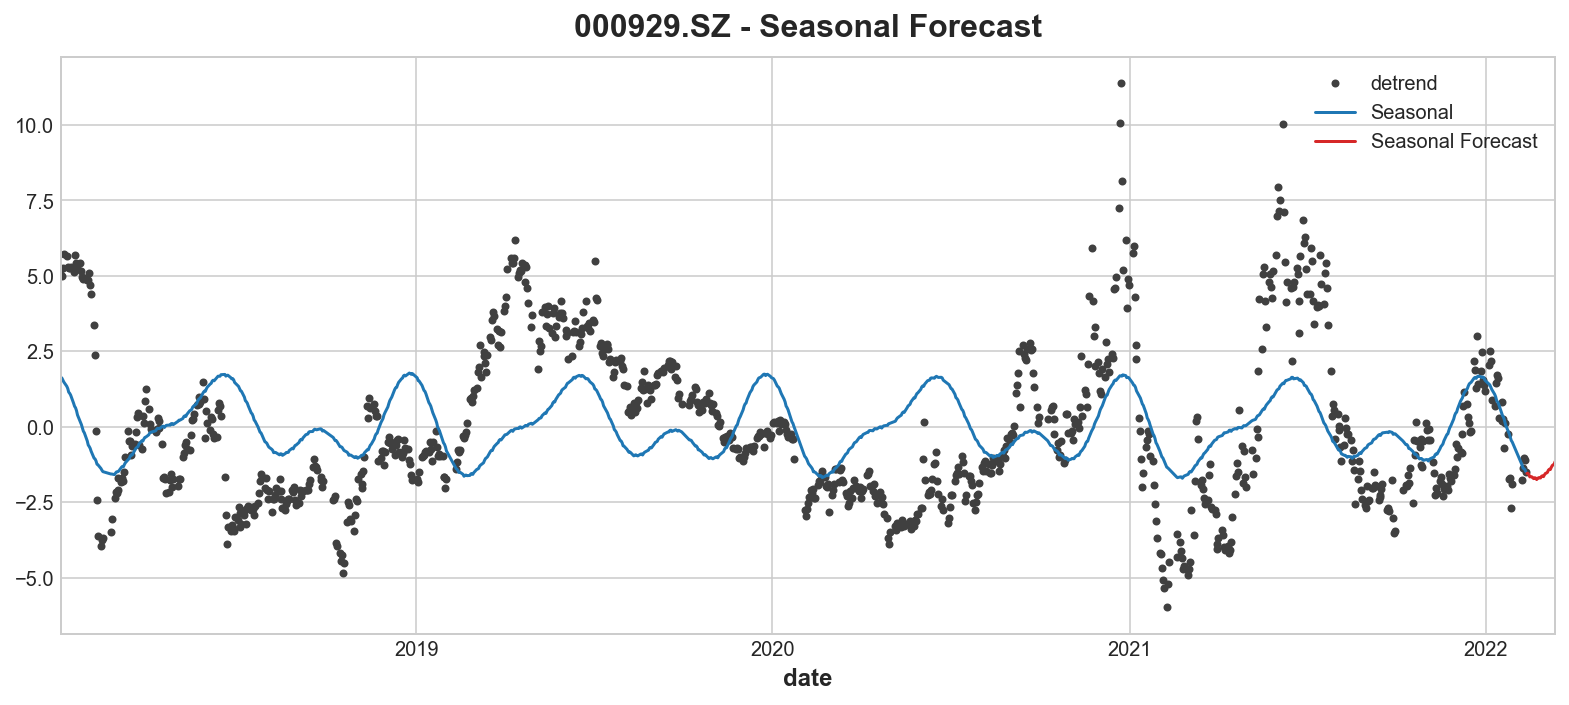

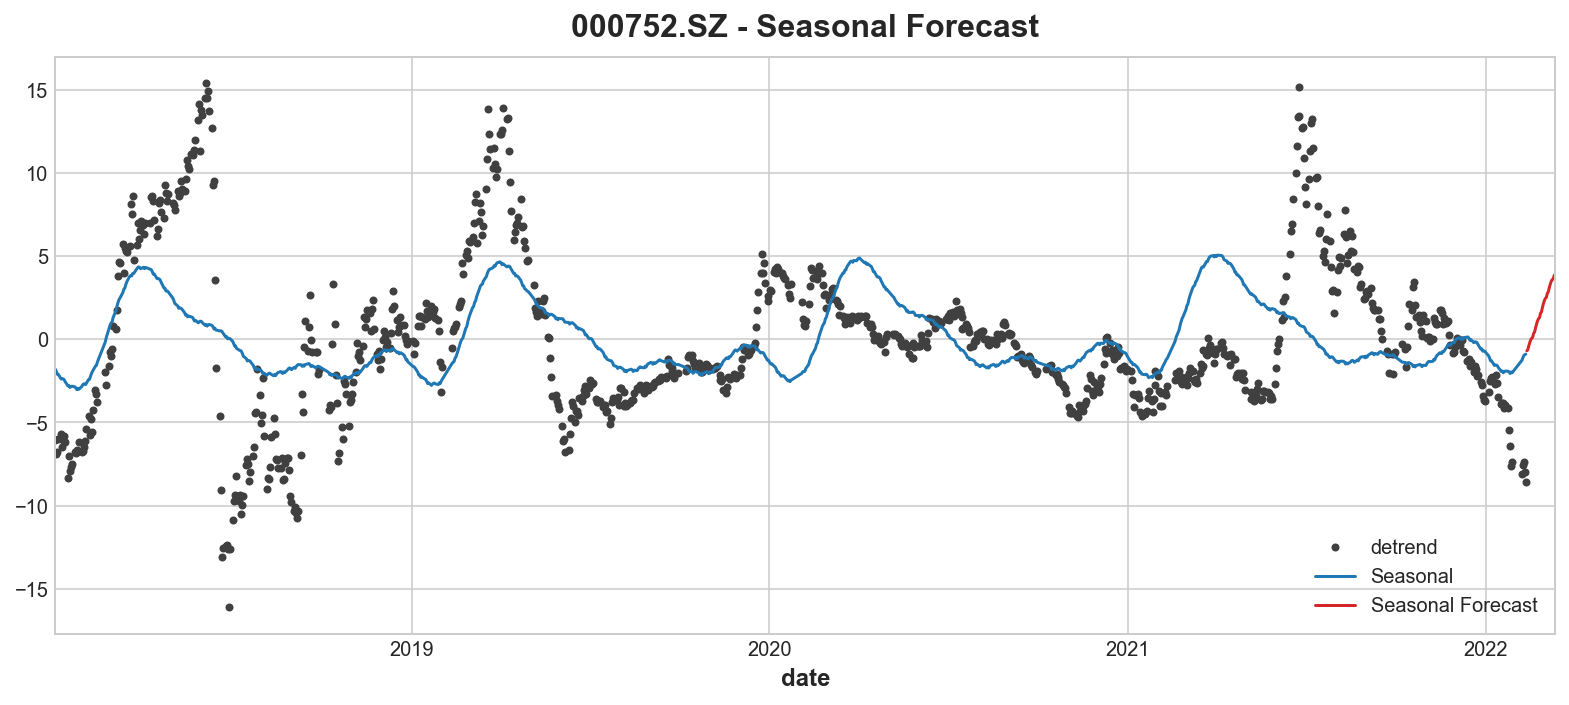

In [16]:
# wind_codes = ['600918.SH']
from statsmodels.tsa.deterministic import DeterministicProcess,CalendarFourier
from sklearn.linear_model import LinearRegression
orders = [  4,
            4,
            4,
            4,
            4,
            4,
            4,]
# _, ax = plt.subplots()
for index, wind_code in enumerate(wind_codes):
    df0 = table[wind_code]
    df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    df0 = df0["2018-01":]
    # plot_periodogram(df0[wind_code],ax=ax ,title=wind_code);


    dp = DeterministicProcess(
        index=df0.index,  # dates from the training data
        constant=True,       # dummy feature for the bias (y_intercept)
        order=3,             # the time dummy (trend)
        drop=True,           # drop terms if necessary to avoid collinearity
    )
    # `in_sample` creates features for the dates given in the `index` argument
    X = dp.in_sample()

    y = df0[wind_code]  # the target

    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    y_pred = pd.Series(model.predict(X), index=X.index)
    y_detrend = y - y_pred
    y_detrend.name = 'detrend'
    # ax = df0.plot(style=".", color="0.5", title=f"{wind_codes[0]} - Linear Trend")
    # _ = y_pred.plot(ax=ax, linewidth=3, label="Trend")
    # ax = y_detrend.plot()
    # ax.set_title(f"{wind_codes[0]} (detrend)");
    # plot_periodogram(y_detrend ,title=wind_code);   
    
    fourier = CalendarFourier(freq='Y', order=orders[index])
    # fourier = Fourier(2*365, order=2)
    dp = DeterministicProcess(
        constant=True,
        index=y_detrend.index,
        order=1,
        seasonal=True,
        drop=True,
        additional_terms=[fourier],
    )
    X = dp.in_sample()
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y_detrend)
    y_pred = pd.Series(model.predict(X), index=y_detrend.index)
    X_fore = dp.out_of_sample(steps=30)
    y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
    _, ax = plt.subplots()
    ax = y_detrend.plot(color='0.25', style='.', title=f"{wind_code} - Seasonal Forecast")
    ax = y_pred.plot(ax=ax, label="Seasonal")
    ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
    _ = ax.legend()


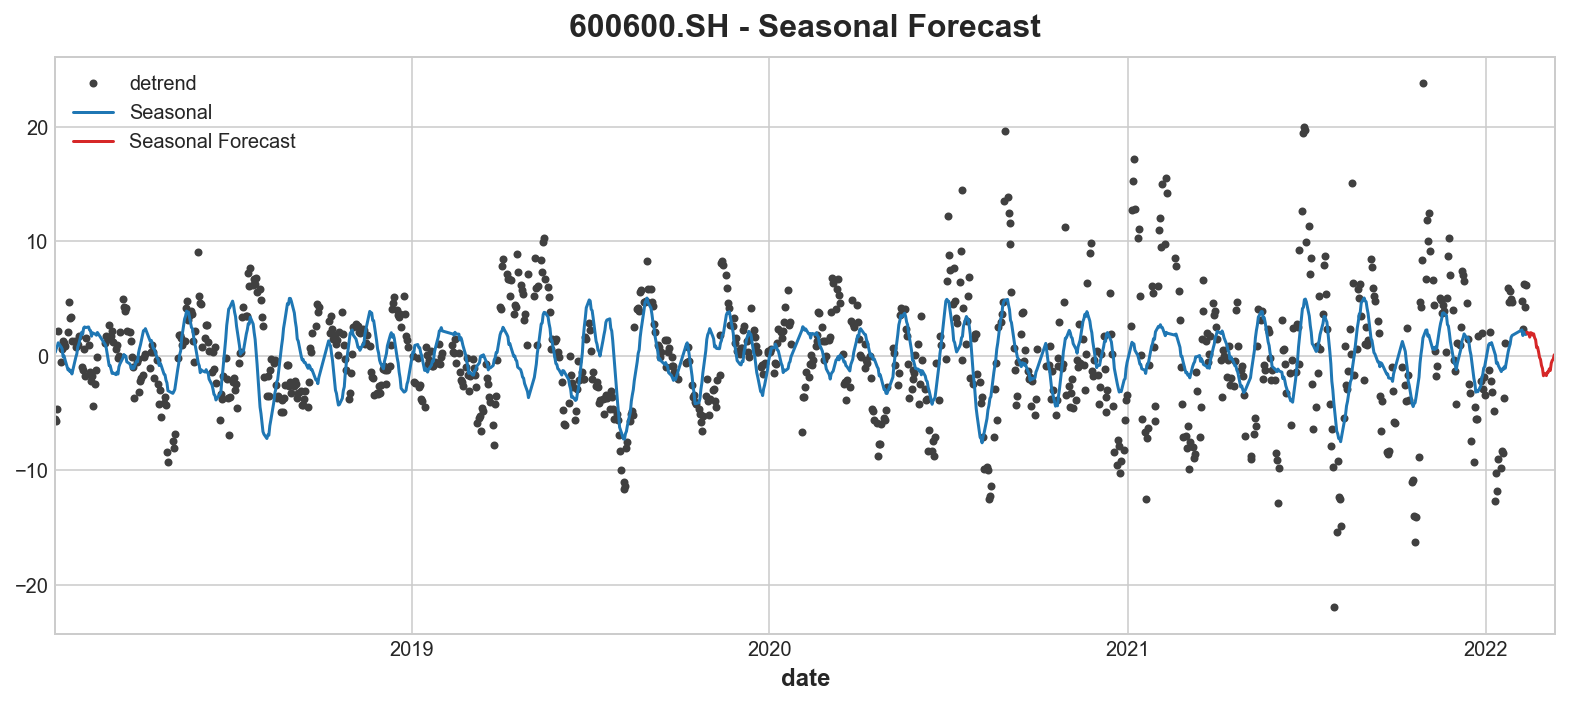

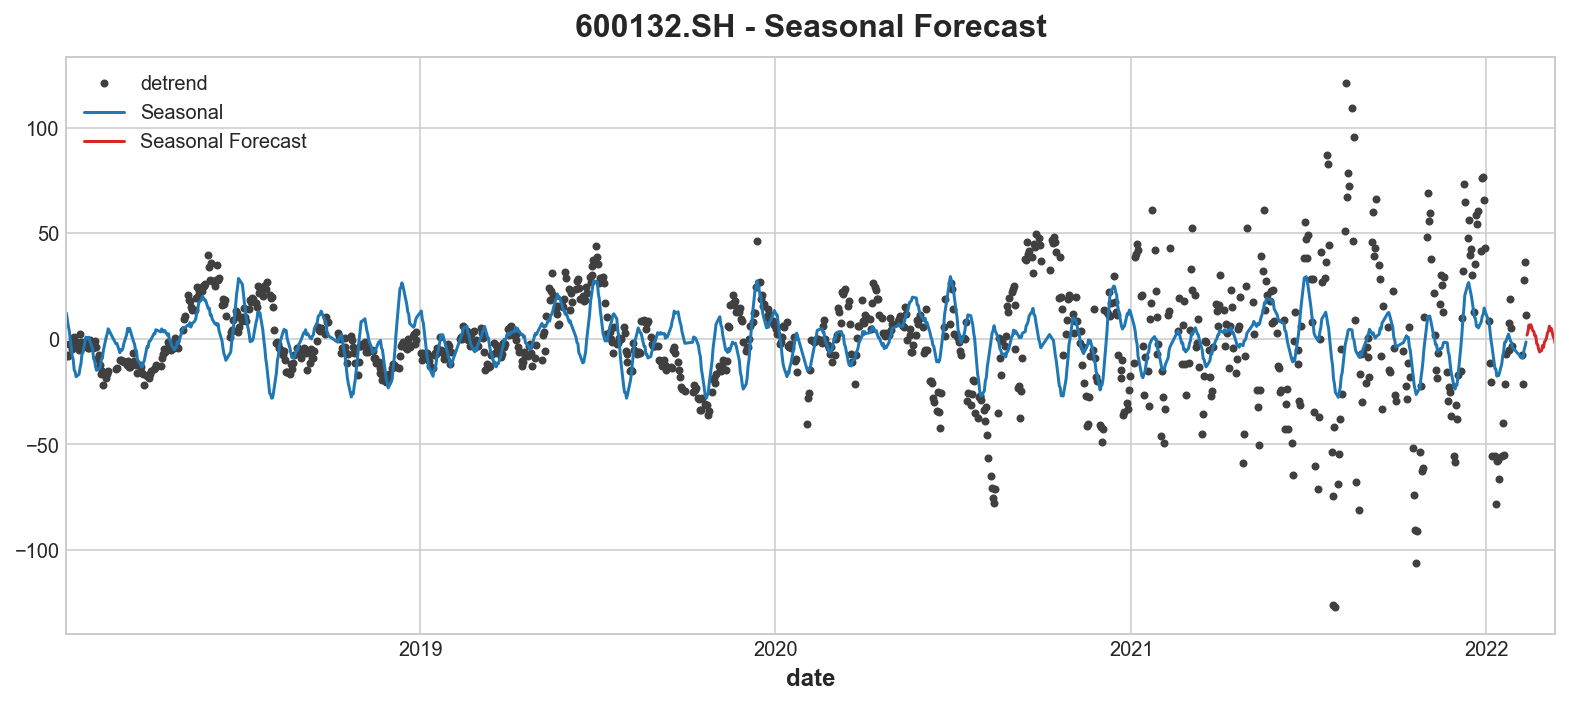

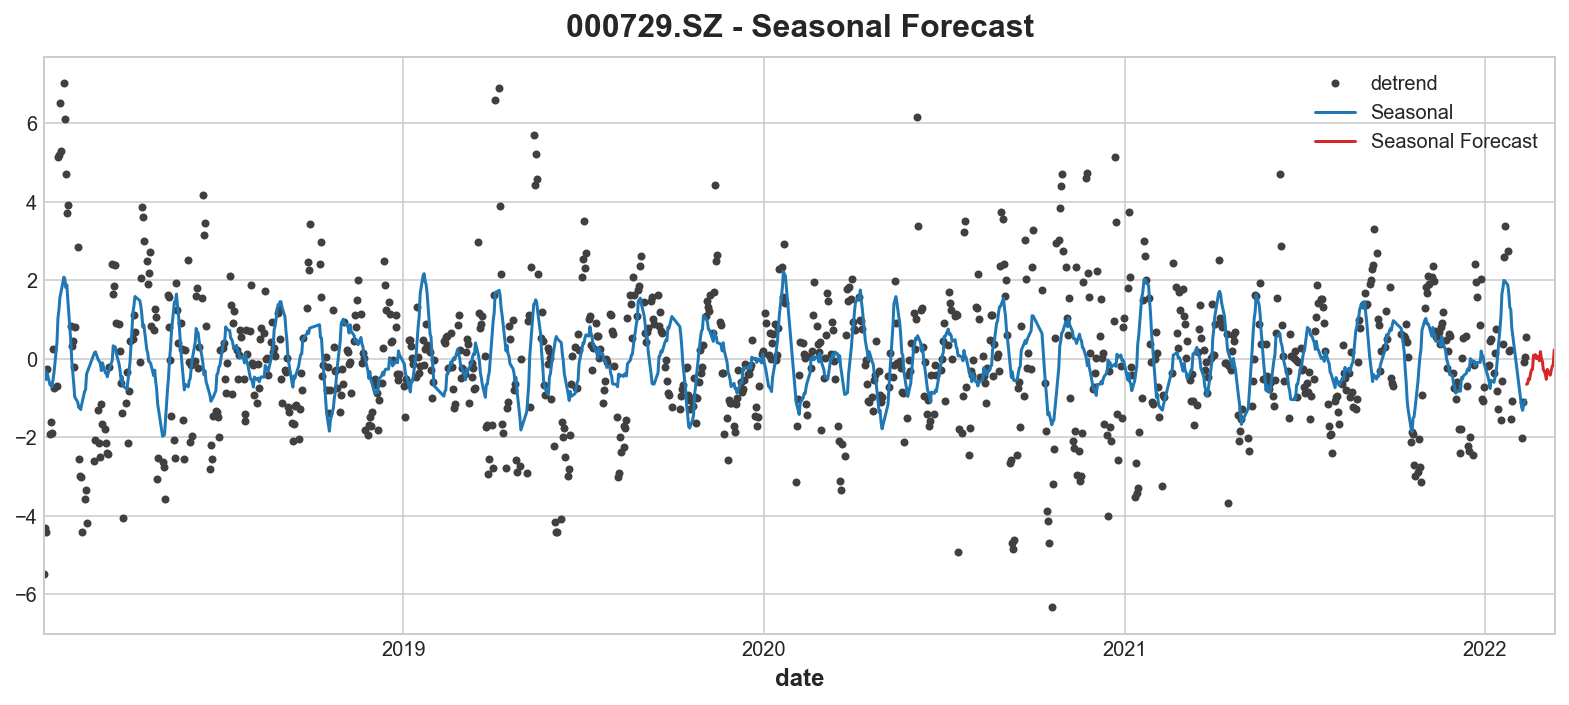

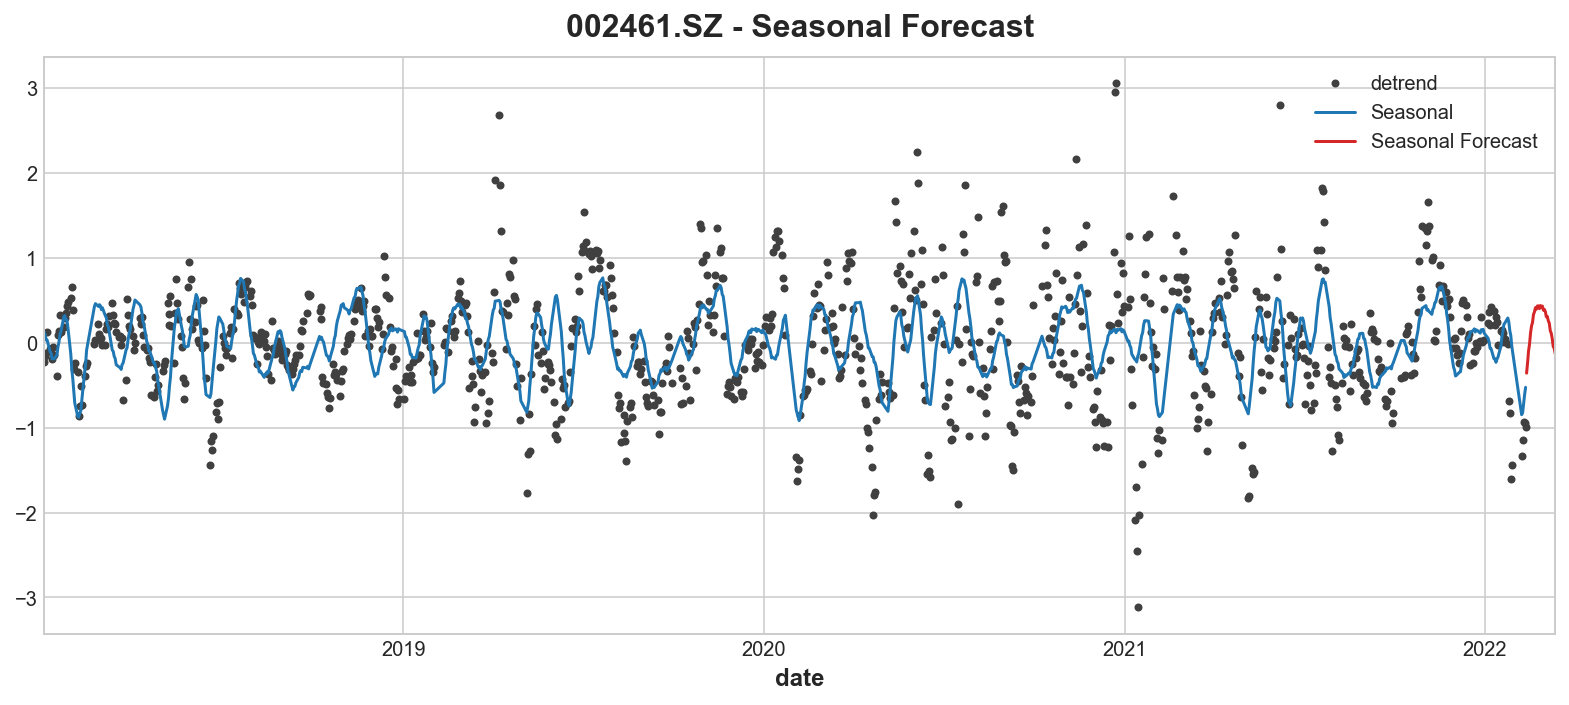

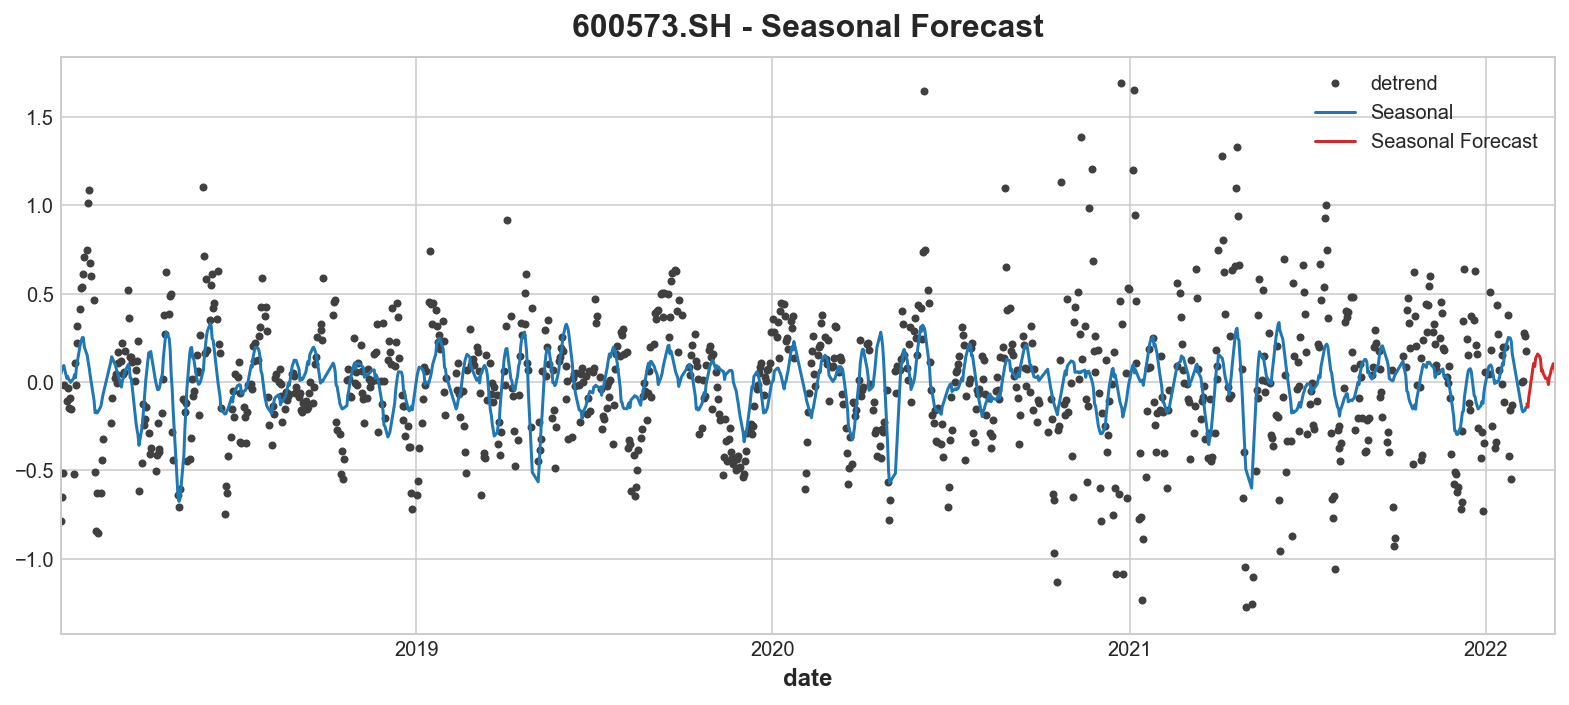

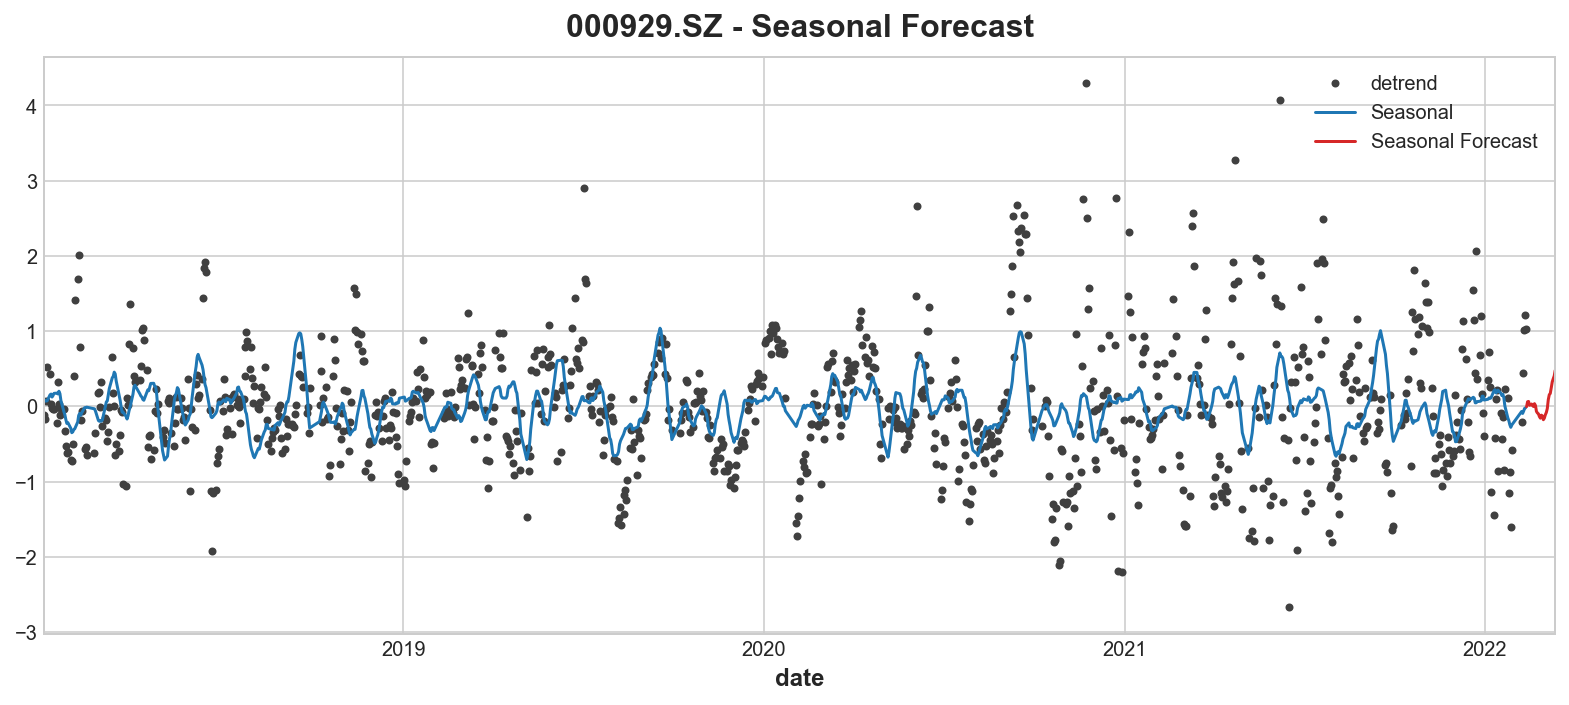

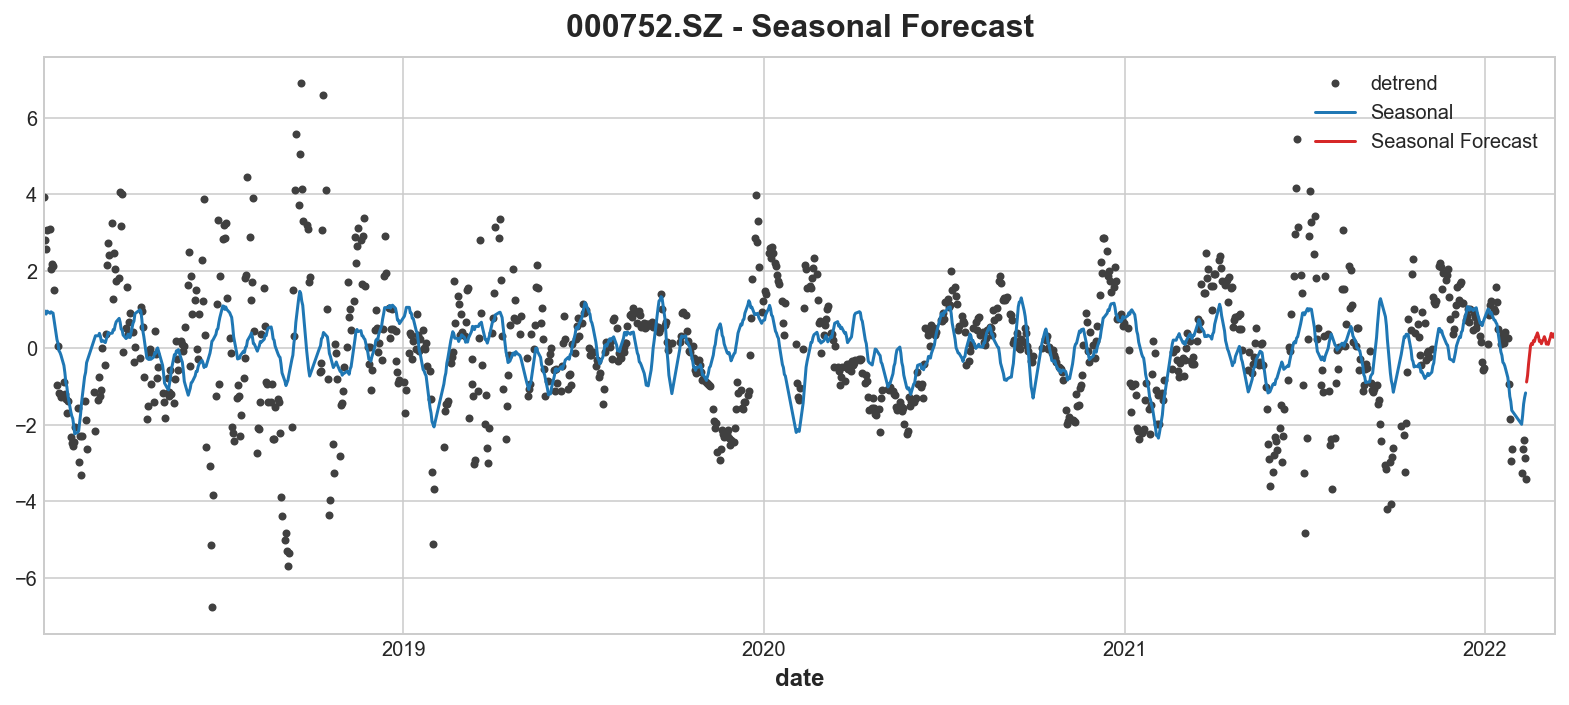

In [17]:
from statsmodels.tsa.deterministic import DeterministicProcess,CalendarFourier
from sklearn.linear_model import LinearRegression
from pyearth import Earth
orders = [  20,
            20,
            20,
            20,
            20,
            20,
            20,]
# _, ax = plt.subplots()
for index, wind_code in enumerate(wind_codes):
    df0 = table[wind_code]
    df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    df0 = df0["2018-01":]
    # plot_periodogram(df0[wind_code],ax=ax ,title=wind_code);    

    # Target and features are the same as before
    y = df0[wind_code]  # the target
    dp = DeterministicProcess(index=df0.index, order=1)
    X = dp.in_sample()

    # Fit a MARS model with `Earth`
    model = Earth()
    model.fit(X, y)

    y_pred = pd.Series(model.predict(X), index=X.index)

    y_pred = pd.Series(model.predict(X), index=X.index)
    y_detrend = y - y_pred
    y_detrend.name = 'detrend'
    
    # plot_periodogram(y_detrend ,title=wind_code);    

    # ax = df0.plot(style=".", color="0.5", title=f"{wind_codes[0]} - Linear Trend")
    # _ = y_pred.plot(ax=ax, linewidth=3, label="Trend")
    # ax = y_detrend.plot()
    # ax.set_title(f"{wind_codes[0]} (detrend)");
    fourier = CalendarFourier(freq='Y', order=orders[index])
    # fourier = Fourier(2*365, order=2)
    dp = DeterministicProcess(
        constant=True,
        index=y_detrend.index,
        order=1,
        seasonal=True,
        drop=True,
        additional_terms=[fourier],
    )
    X = dp.in_sample()
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y_detrend)
    y_pred = pd.Series(model.predict(X), index=y_detrend.index)
    X_fore = dp.out_of_sample(steps=30)
    y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
    _, ax = plt.subplots()
    ax = y_detrend.plot(color='0.25', style='.', title=f"{wind_code} - Seasonal Forecast")
    ax = y_pred.plot(ax=ax, label="Seasonal")
    ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
    _ = ax.legend()
